In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [3]:
annotation_file = './annotations/captions_train2014.json'
PATH = './train2014/'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    if os.path.exists(PATH + 'COCO_train2014_' + '%012d.npy' % (image_id)):
        all_img_name_vector.append(full_coco_image_path)
        all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [4]:
print(len(img_name_vector)/5)

81219.0


In [5]:
print(train_captions[1])
print(img_name_vector[1])

<start> A vase is holding the 1st place winning flowers. <end>
./train2014/COCO_train2014_000000073196.jpg


In [6]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [8]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [9]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [10]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [11]:
max_length = calc_max_length(train_seqs)
print(max_length)

52


In [23]:
img_name_train, img_name_test, cap_train, cap_test = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.1,
                                                                    random_state=0)

img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_train,
                                                                    cap_train,
                                                                    test_size=0.11111,
                                                                    random_state=0)

In [24]:
len(img_name_vector),len(cap_vector),len(img_name_train), len(cap_train), len(img_name_val), len(cap_val),len(img_name_test), len(cap_test)

(406095, 406095, 324875, 324875, 40610, 40610, 40610, 40610)

In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
steps_per_epoch = len(img_name_train) // BATCH_SIZE

In [31]:
len(tokenizer.word_index)

23700

In [32]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')[:-4]+'.npy')
    np.float32(img_tensor)
    img_tensor = img_tensor.reshape((img_tensor.shape[0], 7*7*256))
    new_matrix =  np.zeros((39,7*7*256), dtype="float32")
    new_matrix[:img_tensor.shape[0],:] = img_tensor
    return new_matrix, cap

In [33]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# using map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

W0609 20:12:30.362071 140612036593472 deprecation.py:323] From /home/billzhang/anaconda3/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [34]:
class Encoder(tf.keras.Model):
  def __init__(self, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.fc = tf.keras.layers.Dense(embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.fc(x)
    x = tf.nn.relu(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [37]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 39, 12544]), TensorShape([64, 52]))

In [38]:
encoder = Encoder(embedding_dim, units, BATCH_SIZE)

In [39]:
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 39, 512)
Encoder Hidden state shape: (batch size, units) (64, 512)


In [40]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [41]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 512)
Attention weights shape: (batch_size, sequence_length, 1) (64, 39, 1)


In [42]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)
        self.softmax =tf.keras.layers.Softmax()
    
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = self.fc1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc2(output)
        sm = self.softmax(x)
        return sm, x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [43]:
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
hidden = decoder.reset_state(batch_size=64)
hidden.shape

TensorShape([64, 512])

In [44]:
_, sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

In [45]:
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 23701)


In [48]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [49]:
optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [50]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [51]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      _, predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      lossa = loss_function(targ[:, t], predictions)
      train_loss(lossa)
      train_accuracy(targ[:, t], predictions)
      loss += lossa

      dec_input = tf.expand_dims(targ[:, t], 1)
    

  batch_loss = (loss / int(targ.shape[1]))
  

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs6/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs6/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [31]:
encoder.load_weights('./weights/encoder_checkpoint6')
decoder.load_weights('./weights/decoder_checkpoint6')

In [68]:
EPOCHS = 1
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    encoder.save_weights('./weights/encoder_checkpoint6')
    decoder.save_weights('./weights/decoder_checkpoint6')

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.5331
Epoch 1 Batch 100 Loss 0.4799
Epoch 1 Batch 200 Loss 0.5259
Epoch 1 Batch 300 Loss 0.5364
Epoch 1 Batch 400 Loss 0.5091
Epoch 1 Batch 500 Loss 0.5563
Epoch 1 Batch 600 Loss 0.5624
Epoch 1 Batch 700 Loss 0.5454
Epoch 1 Batch 800 Loss 0.5551
Epoch 1 Batch 900 Loss 0.5490
Epoch 1 Batch 1000 Loss 0.5017
Epoch 1 Batch 1100 Loss 0.5782
Epoch 1 Batch 1200 Loss 0.5081
Epoch 1 Batch 1300 Loss 0.5164
Epoch 1 Batch 1400 Loss 0.5552
Epoch 1 Batch 1500 Loss 0.5072
Epoch 1 Batch 1600 Loss 0.5885
Epoch 1 Batch 1700 Loss 0.4814
Epoch 1 Batch 1800 Loss 0.5724
Epoch 1 Batch 1900 Loss 0.5149
Epoch 1 Batch 2000 Loss 0.5874
Epoch 1 Batch 2100 Loss 0.5635
Epoch 1 Batch 2200 Loss 0.5380
Epoch 1 Batch 2300 Loss 0.5278
Epoch 1 Batch 2400 Loss 0.5319
Epoch 1 Batch 2500 Loss 0.5214
Epoch 1 Batch 2600 Loss 0.5399
Epoch 1 Batch 2700 Loss 0.5809
Epoch 1 Batch 2800 Loss 0.5385
Epoch 1 Batch 2900 Loss 0.4966
Epoch 1 Batch 3000 Loss 0.5244
Epoch 1 Batch 3100 Loss 0.5355
Epoch 1 Batch 3200 L

In [63]:
encoder.save_weights('./weights/encoder_checkpoint6')
decoder.save_weights('./weights/decoder_checkpoint6')

In [70]:
def greedy_search(image_name):
    img_tensor = np.load(image_name[:-4]+'.npy')
    np.float32(img_tensor)
    img_tensor = img_tensor.reshape((img_tensor.shape[0], 7*7*256))
    new_matrix =  np.zeros((39,7*7*256), dtype="float32")
    new_matrix[:img_tensor.shape[0],:] = img_tensor


    inputs = tf.convert_to_tensor(new_matrix)
    result = ''
    inputs = tf.expand_dims(inputs, 0)
    inputs.shape


    hidden = tf.zeros((1, units))
    hidden.shape
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in range(max_length):
            _, predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)


            predicted_id = tf.argmax(predictions[0]).numpy()
            if tokenizer.index_word[predicted_id] == '<end>':
                break

            result += tokenizer.index_word[predicted_id] + ' '

            

            dec_input = tf.expand_dims([predicted_id], 0)
    return result[:-1]
    



In [71]:
all_ref = {}
for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    if os.path.exists(PATH + 'COCO_train2014_' + '%012d.npy' % (image_id)):
        if full_coco_image_path not in all_ref:
            all_ref[full_coco_image_path] = [caption.split()]
        else:
            all_ref[full_coco_image_path].append(caption.split())

In [72]:
def calc_length(list):
    length = 0
    for l in list:
        if l != 4:
            length += 1
        elif l == 4:
            break
    return length
    

In [73]:
def beam_search(image_name, beam_index,beam_alpha=0.7):
    debug = False
    #image_name = img_name_train[rid]
    img_tensor = np.load(image_name[:-4]+'.npy')
    np.float32(img_tensor)
    img_tensor = img_tensor.reshape((img_tensor.shape[0], 7*7*256))
    new_matrix =  np.zeros((39,7*7*256), dtype="float32")
    new_matrix[:img_tensor.shape[0],:] = img_tensor

    inputs = tf.convert_to_tensor(new_matrix)
    inputs = tf.expand_dims(inputs, 0)
    hidden = tf.zeros((1, units))

    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    start = [tokenizer.word_index['<start>']]

    start_word = [[start, 0.0, dec_hidden]]
    total = []
    
    
    for itter in range(max_length):
    #while len(estart_word[0]) < max_length:
        temp = []
        for s in start_word:
            if debug:
                print("Debug:",len(s[0]),"Word",s[0],"Prob",s[1])
            
            #for s in start_word:
            if (s[0][-1] != tokenizer.word_index['<end>']):
                dec_input = tf.expand_dims([s[0][-1]], 0)
                softmax, predictions, dec_hidden, attention_weights = decoder(dec_input,s[2],enc_out)
                word_preds = tf.argsort(softmax[0],direction = 'DESCENDING')[:beam_index].numpy()
                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += np.log(softmax[0][w].numpy())
                    #prob *= softmax[0][w].numpy()
                    temp.append([next_cap, prob,dec_hidden])
            else:
                temp.append(s)
                
            
        start_word = temp
        
        for ind in start_word:
            if debug:
                print("*Debug:",len(ind[0]),"Word",ind[0],"Prob",ind[1])
        
        # Sorting according to the probabilities
        #start_word = sorted(start_word, reverse=False, key=lambda l: l[1]*(1/(len(l[0])**0.7)))
        #for s in start_word:
        #    s[1] =  s[1]*(1/(calc_length(s[0])**beam_alpha))
        
        start_word = sorted(start_word, reverse=True, key=lambda l: l[1]*(1/(len(l[0])**beam_alpha)))
        #total = total + start_word
        start_word = start_word[:beam_index]
        
        for ind in start_word:
            if debug:
                print("**Debug:",len(ind[0]),"Word",ind[0],"Prob",ind[1])                    
                            
                            
        #print(start_word)
    total = start_word[0][0]
    #total = sorted(start_word, reverse=True, key=lambda l: l[1]*(1/(calc_length(l[0])**beam_alpha)))[0][0]
    #print (total)
    #total = total[-2][0]
    intermediate_caption = [tokenizer.index_word[i] for i in total]

    final_caption = []

    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    print ("beam search: k = {}".format(beam_index))
    print (final_caption)
    return final_caption

In [74]:
def print_real_caption(image_name):
    print("real_captions:")
    refs = all_ref[image_name]
    for ref in refs:
        print (' '.join(ref))
    return refs

In [75]:
#Bleu Score
def calcBleuScore(image_name, sentence):
    debug = False
    captions = all_ref[image_name]
    reference = []
    for c in captions:
        c = " ".join(c)
        inp_list = re.sub("[^<*\w>*]", " ", c).lower().split()
        reference.append(inp_list[1:-1])
    candidate = re.sub("[^\w]", " ", sentence).lower().split()
    #test cases
    #reference = [['this', 'is', 'a', 'test']]
    #reference = [['this', 'is','test']]
    #reference = [['this', 'is', 'test'],['this', 'is','a','test']]
    #candidate = ['this', 'is', 'a', 'test']

    bleu_score = np.zeros([4,1])    

    bleu_score[0] = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu_score[1] = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu_score[2] = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    bleu_score[3] = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))
    
#     if (debug):
#         print('Reference:\n', reference)
#         print('Candidate:\n', candidate)
#         print('*********************************************************************************')
    print('Individual 1-gram: %.3f' % bleu_score[0])
    print('Individual 2-gram: %.3f' % bleu_score[1])
    print('Individual 3-gram: %.3f' % bleu_score[2])
    print('Individual 4-gram: %.3f' % bleu_score[3])
        
    return bleu_score

./train2014/COCO_train2014_000000169174.jpg
(3, 7, 7, 256)
real_captions:
<start> a black and white photo of a parked motorcycle <end>
<start> A motorcycle that is parked and standing on a street. <end>
<start> A black and white motorcycle parked on concrete. <end>
<start> A white and black motorcycle parked in the sun. <end>
<start> A motorcycle that is parked on some pavement. <end>
beam search: k = 2
a motorcycle is parked on the side of the road
beam search: k = 3
a motorcycle parked on the side of a road
beam search: k = 5
a motorcycle parked on the side of a road
beam search: k = 8
a motorcycle parked on the side of a road
beam search: k = 10
a motorcycle parked on the side of a road
Individual 1-gram: 0.778
Individual 2-gram: 0.500
Individual 3-gram: 0.143
Individual 4-gram: 0.000


/home/billzhang/anaconda3/envs/test2/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


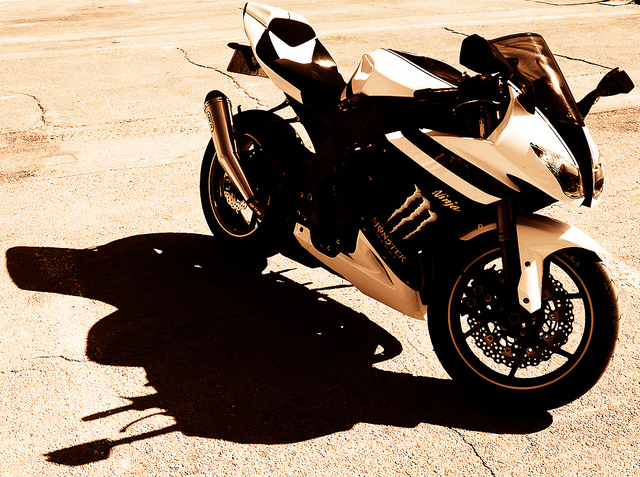

In [77]:
rid = np.random.randint(0, len(img_name_val))
image_name = img_name_val[rid]
print (image_name)
#image_name = "./train2014/COCO_train2014_000000449136.jpg"
img_tensor = np.load(image_name[:-4]+'.npy')
print (img_tensor.shape)
refs = print_real_caption(image_name)
greedy_search(image_name)
beam_search(image_name, 2)
beam_search(image_name, 3)
beam_search(image_name, 5)
beam_search(image_name, 8)
sentence = beam_search(image_name, 10)
calcBleuScore(image_name, sentence)
Image.open(image_name)